# Estimating the Ground State Energy of the Hydrogen Molecule using the Variational Quantum Eigensolver

In this notebook, you will be able run an VQE algorithm on the molecular Hydrogen molecule H$_2$ in the minimal basis. The VQE algorithm tries to use a parametrized quantum circuit (ansatz) to simulate the ground state wavefunction of a molecule. 

A parametrized quantum circuit could be written as 

<h1><center>$\left|\Psi(\theta)\right>=U(\theta)\left|0\right>$</center></h1>

in which $\theta$ are the unknown parameters. The energy expectation value of the wavefunction is

<h1><center>$E(\theta)=\left<\Psi(\theta)|H|\Psi(\theta)\right>$</center></h1>

The VQE algorithm measures the energy expectation value on a quantum computer, and then relies on a classical computer to find new parameters $\theta^\ast$ that lowers the energy. This process is done iteratively until the energy has converged. 

The second quantized electronic Hamiltonian is 

<h1><center>$H=\sum_{pq}{h_{pq}a^\dagger_pa_q}+\frac{1}{2}\sum_{pqrs}{g_{pqrs}a^\dagger_pa_qa^\dagger_ra_s}$</center></h1>

in which $a^\dagger_p$ and $a_p$ are creation and annhilation operators

<h1><center>$a^\dagger_p\left|0\right>=\left|1\right>, a_p\left|1\right>=\left|0\right>$</center></h1>

These operators could be mapped into Pauli matrices by Jordan-Wigner transformation (JWT) for example. 

<h1><center>$a^\dagger_p\rightarrow I^{\otimes p-1}\otimes[(X_p-iY_p)/2]\otimes Z^{\otimes N-p}$</center></h1>
<h1><center>$a_p\rightarrow I^{\otimes p-1}\otimes[(X_p+iY_p)/2]\otimes Z^{\otimes N-p}$</center></h1>

As you can see, upon JWT, the Hamiltonian becomes a linear combination of tensor product of Pauli matrices. 

<h1><center>$H=\sum_i{w_iP_i}$</center></h1>
and these matrices could be directly measured on quantum computers. 

Moving to ansatz, people have developed many different ansatzes for VQE. We will focus on one of the first ansatz developed for VQE, the unitary Coupled Cluster, which is,
<h1><center>$\left|\Psi\right>=e^{T-T^\dagger}\left|HF\right>$</center></h1>

in which $T$ is,
<h1><center>$T=\sum_{ia}{t_i^aE_i^a}+\sum_{i>j,a>b}{t_{ij}^{ab}E_{ij}^{ab}}+\cdots$</center></h1>
and $\left|HF\right>$ is the Hartree-Fock state. 

The HF state is easy to prepare on a quantum computer. For the $e^{T-T^\dagger}$ operator, people ususally do is
to truncate the summation to the first two terms, which yields a very good wave function ansatz, and then transform
the $E$ operator to Pauli matrices. 

<h1><center>$\left|\Psi\right>=e^{\sum_j{t_jP_j}}\left|HF\right>$</center></h1>
which could be prepared on a quantum computer, and the $t_j$ are the parameters. 

## Setup

First, make sure that you have the latest version of Qiskit installed. To upgrade your Qiskit package, run the following command:

```bash
pip install --upgrade qiskit
```

Get an API key from IonQ. This will be used by the IonQ provider inside Qiskit to submit circuits to the IonQ platform.

After securing an API key, install the python package `qiskit_ionq` using `pip`:

```bash
pip install qiskit_ionq
```

(IonQ's adapter for Qiskit is currently in private beta -- your feedback is welcomed!)

### (Optional) Extra Dependencies

Some examples use additional Python dependencies; please make sure to `pip install` them as needed.

Dependencies:
* `matplotlib`: To run `qiskit.visualization.plot_histogram`.

**NOTE**: The provider expects an API key to be supplied via the `token` keyword argument to its constructor. If no token is directly provided, the provider will check for one in the `QISKIT_IONQ_API_TOKEN` environment variable.

Now that the Python package has been installed, you can import and instantiate the provider:

In [1]:
#import Aer here, before calling qiskit_ionq_provider
from qiskit import Aer

from qiskit_ionq import IonQProvider 

#Call provider and set token value
ionq_provider = IonQProvider(token='your token')

The `provider` instance can now be used to create and submit circuits to IonQ.

### Backend Types

The IonQ provider supports two backend types:
* `ionq_simulator`: IonQ's simulator backend.
* `ionq_qpu`: IonQ's QPU backend.

To view all current backend types, use the `.backends` property on the provider instance:

In [46]:
ionq_provider.backends()

[<IonQSimulatorBackend('ionq_simulator')>, <IonQQPUBackend('ionq_qpu')>]

We now import every library/module that will be needed.

In [2]:
import numpy as np

from qiskit import execute
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.utils import QuantumInstance
from qiskit.algorithms import VQE
from qiskit.algorithms.optimizers import COBYLA, ADAM, L_BFGS_B, SLSQP, SPSA
from qiskit import Aer
from qiskit.circuit import Parameter
from qiskit.circuit.parametervector import ParameterVectorElement

from qiskit_nature.drivers import PySCFDriver, UnitsType, Molecule
from qiskit_nature.circuit.library import HartreeFock
from qiskit_nature.problems.second_quantization.electronic import ElectronicStructureProblem
from qiskit_nature.mappers.second_quantization import JordanWignerMapper
from qiskit_nature.converters.second_quantization import QubitConverter

from qiskit.algorithms import NumPyMinimumEigensolver
from qiskit_nature.algorithms.ground_state_solvers import GroundStateEigensolver

from qiskit_nature.runtime import VQEProgram

from matplotlib import pyplot as plt
%matplotlib inline 

/opt/anaconda3/envs/py3/lib/python3.9/site-packages/pyscf/lib/misc.py:46: H5pyDeprecationWarning: Using default_file_mode other than 'r' is deprecated. Pass the mode to h5py.File() instead.
  h5py.get_config().default_file_mode = 'a'


### First, let's define the unitary CCSD ansatz. For such a two-electron, four-orbital problem, the UCCSD ansatz could be moldeled by just one parameter: $\left|\Psi\right>=e^{i\theta Y_0X_1X_2X_3}$. 

In [7]:
class UCCAnsatz():

    def __init__(self, params, num_particles, num_spin_orbitals):

        # number of qubits 
        self.num_of_qubits = num_spin_orbitals

        # number of parameters
        self.num_params = len(params)

        # parameters
        self.params = []
        for index in range(self.num_params):
            p = Parameter("t"+str(index))
            self.params.append(ParameterVectorElement(p, index))

    def UCC1(self):

        qc = QuantumCircuit(4)

        # basis rotation
        qc.rx(np.pi / 2, 0)
        qc.h(1)
        qc.h(2)
        qc.h(3)

        # parameter theta_0
        qc.cx(0, 1)
        qc.cx(1, 2)
        qc.cx(2, 3)
        qc.rz(self.params[0], 3)
        qc.cx(2, 3)
        qc.cx(1, 2)
        qc.cx(0, 1)

        # basis rotation
        qc.rx(-np.pi / 2, 0)
        qc.h(1)
        qc.h(2)
        qc.h(3)


        return qc

### For the next function, we need to form the electronic structure problem, obtain the electronic Hamiltonian, and transform it with the JWT. We also diagonalize the Hamiltonian classically as a reference value. 

In [8]:
################## Hamiltonian Definition #######################################

def GetHamiltonians(mol):

    # construct the driver
    driver = PySCFDriver(molecule=mol, unit=UnitsType.ANGSTROM, basis='sto6g')

    # the electronic structure problem
    problem = ElectronicStructureProblem(driver)

    # get quantum molecule
    q_molecule = driver.run()

    # classical eigenstate
    np_solver = NumPyMinimumEigensolver()
    np_groundstate_solver = GroundStateEigensolver(QubitConverter(JordanWignerMapper()), np_solver)

    np_result = np_groundstate_solver.solve(problem)
    print(f"Classical results is {np_result.eigenenergies}")

    # generate the second-quantized operators
    second_q_ops = problem.second_q_ops()

    # construct a qubit converter
    qubit_converter = QubitConverter(JordanWignerMapper())

    # qubit Operations 
    qubit_op = qubit_converter.convert(second_q_ops[0])

    # return the qubit operations
    return qubit_op


### Let's now put things together. The overall circuit is constructed by first initilizing the HF state, and applying the UCCSD ansatz. 

In [9]:
def constructAnsatz(params):

    # initialize the HF state
    hf_state = HartreeFock(4, [1, 1], QubitConverter(JordanWignerMapper()))

    # VQE circuit
    ansatz = UCCAnsatz(params, 2, 4).UCC1()

    # add initial state
    ansatz.compose(hf_state, front=True, inplace=True)

    # return the circuit
    return ansatz


### Finally, we define a classical optimizer. Here we use the COBYLA optimizer. We pass the parametrized circuit into the qiskit's VQE function, and we set the initial values for the parameter to be zero.  

In [36]:
def constructCircuit(params, mol, backend_id):

    # Hamiltonian
    qubit_op = GetHamiltonians(mol)

    # Optimizer
    optimizer = COBYLA()

    # ansatz
    ansatz = constructAnsatz(params)
    print(ansatz)

    # initial parameters 
    init_params = {}
    for index in range(len(params)):
        p = Parameter("t"+str(index))
        init_params[ParameterVectorElement(p, index)] = 0.0

    # backend 
    if (backend_id == "qasm_simulator"):
        backend = Aer.get_backend("qasm_simulator")
    elif (backend_id == "ionq_qpu"):
        backend = ionq_provider.get_backend("ionq_qpu")

    def job_callback(job_id, job_status, queue_position, job) -> None:
        '''
        Printing logs for debugging.
        The function is the parameter job_callback of QuantumInstance
        :param job_id:
        :param job_status:
        :param queue_position:
        :param job:
        :return:
        '''
        print(f"[API JOB-CALLBACK] Job Id:         {job_id}")
        print(f"[API JOB-CALLBACK] Job status:     {job_status}")
        print(f"[API JOB-CALLBACK] Queue position: {queue_position}")
        print(f"[API JOB-CALLBACK] Job:            {job}")

    ionq_quantum_instance = QuantumInstance(backend=backend, job_callback=job_callback)

    counts = []
    values = []
    stds   = []
    def store_intermediate_result(eval_count, parameters, mean, std):
        counts.append(eval_count)
        values.append(mean)
        stds.append(std)

    # VQE algorithm
    algorithm = VQE(ansatz,
                    optimizer=optimizer,
                    initial_point = np.array([0.0]),
                    callback=store_intermediate_result,
                    quantum_instance=ionq_quantum_instance)

    result = algorithm.compute_minimum_eigenvalue(qubit_op)
    print(result)
    print("Optimized VQE Energy ", result.eigenvalue.real)
    print(values)


### Let's now perform the VQE optimization on a simulator. 

In [39]:
# Execute program with default parameters
def run(backend_id="qasm_simulator"):

    molecule = Molecule(geometry=[['H',  [0., 0., 0.]],
                                  ['H', [0., 0., 0.75]]],
                                  charge=0, multiplicity=1)
    opt_values = constructCircuit([0.0], molecule, backend_id)

run()

Classical results is [-1.85131129+2.77025096e-17j]
     ┌───┐┌─────────┐                                           ┌──────────┐
q_0: ┤ X ├┤ RX(π/2) ├──■─────────────────────────────────────■──┤ RX(-π/2) ├
     ├───┤└─────────┘┌─┴─┐                                 ┌─┴─┐└──┬───┬───┘
q_1: ┤ H ├───────────┤ X ├──■───────────────────────────■──┤ X ├───┤ H ├────
     ├───┤   ┌───┐   └───┘┌─┴─┐                       ┌─┴─┐├───┤   └───┘    
q_2: ┤ X ├───┤ H ├────────┤ X ├──■─────────────────■──┤ X ├┤ H ├────────────
     ├───┤   └───┘        └───┘┌─┴─┐┌───────────┐┌─┴─┐├───┤└───┘            
q_3: ┤ H ├─────────────────────┤ X ├┤ RZ(t0[0]) ├┤ X ├┤ H ├─────────────────
     └───┘                     └───┘└───────────┘└───┘└───┘                 
{   'aux_operator_eigenvalues': None,
    'cost_function_evals': 19,
    'eigenstate': {'0101': 0.9946144039274718, '1010': 0.10364452469860624},
    'eigenvalue': -1.849466737807071,
    'optimal_parameters': {ParameterVectorElement(t0[0]): 0.15615},
    

### Let's plot the optimization process. 

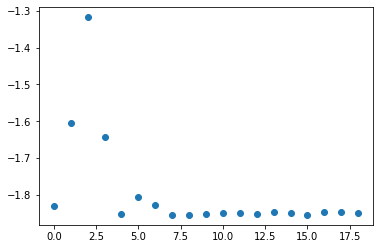

In [43]:
opt_process = [-1.8308337397334875, -1.6045286426151377, -1.3176850880519417, -1.642972785671419, -1.853378862063689, -1.806712185391583, -1.8281518913000796, -1.853965175510973, -1.8546227409607912, -1.8512623145326073, -1.8499200431393457, -1.8490846844773303, -1.8508890835046492, -1.8474757232657733, -1.8492536553877457, -1.8544537700503756, -1.8461599187778577, -1.8476358718744068, -1.849466737807071]
plt.plot(opt_process, linestyle="", marker="o")
plt.show()

### Now, let's try the same thing on actual IonQ hardware!

In [ ]:
run("ionq_qpu")

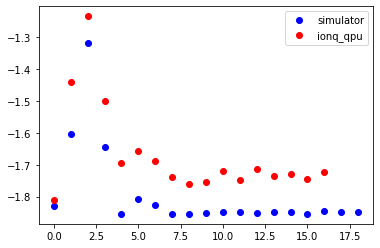

In [50]:
opt_process_exp = [-1.8112359199652812, -1.4416498480789817, -1.2335035452225904, -1.4989706208229303, -1.6937521890989031, -1.6557546667316045, -1.6898027909394815, -1.740016937435431, -1.7592133266130963, -1.755505060521276, -1.7199835843097526, -1.7476529655074913, -1.7142357090197362, -1.7366022956905651, -1.7307574124517149, -1.7437590702130892, -1.721561556686939]
plt.plot(opt_process, linestyle="", marker="o", color="b", label="simulator")
plt.plot(opt_process_exp, linestyle="", marker="o", color="r", label="ionq_qpu")
plt.legend()
plt.show()

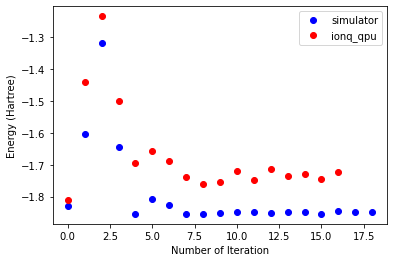

In [5]:
opt_process_exp = [-1.8112359199652812, -1.4416498480789817, -1.2335035452225904, -1.4989706208229303, -1.6937521890989031, -1.6557546667316045, -1.6898027909394815, -1.740016937435431, -1.7592133266130963, -1.755505060521276, -1.7199835843097526, -1.7476529655074913, -1.7142357090197362, -1.7366022956905651, -1.7307574124517149, -1.7437590702130892, -1.721561556686939]
opt_process = [-1.8308337397334875, -1.6045286426151377, -1.3176850880519417, -1.642972785671419, -1.853378862063689, -1.806712185391583, -1.8281518913000796, -1.853965175510973, -1.8546227409607912, -1.8512623145326073, -1.8499200431393457, -1.8490846844773303, -1.8508890835046492, -1.8474757232657733, -1.8492536553877457, -1.8544537700503756, -1.8461599187778577, -1.8476358718744068, -1.849466737807071]
plt.plot(opt_process, linestyle="", marker="o", color="b", label="simulator")
plt.plot(opt_process_exp, linestyle="", marker="o", color="r", label="ionq_qpu")
plt.xlabel("Number of Iteration")
plt.ylabel("Energy (Hartree)")
plt.legend()
plt.show()

As you can see, due to noise on the QPU, it converges to a much higher energy than that of the simulator. 